In [1]:
import plotly
import numpy as np 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt 
import os
import math
import glob
from scipy import interpolate
from scipy.ndimage import gaussian_filter
#from sklearn.neighbors import NearestNeighbors

In [ ]:
df2=pd.read_pickle("reweighted.pkl")
df2

In [3]:
md_lengths=[]   # to store md lenth of each GPU
for gpu_id in df2.gpu_id.unique():
    md_lengths.append(max(df2[df2.gpu_id==gpu_id].md_step))

md_length=min(md_lengths)
md_length

170999

In [ ]:
df=df2.sort_values('md_step')
df

In [14]:
RMSD= np.array(df['rmsd'].values.tolist())
Q= np.array(df['Q'].values.tolist())    # all frames
weights= np.array(df['weight'].values.tolist())    # all frames

In [6]:
print(RMSD,Q)

[3.92784299 0.88182561 1.15329152 ... 6.07148241 7.60181475 5.20056789] [4.78073349e-01 9.99559191e-01 9.99817129e-01 ... 1.31485782e-01
 1.26698749e-20 2.83074338e-01]


In [7]:
RMSDmin, RMSDmax, Qmin, Qmax= min(RMSD), max(RMSD), min(Q), max(Q)
print(RMSDmin, RMSDmax, Qmin, Qmax)

0.8818256141442549 12.384170826503675 4.634023824515004e-56 0.9999272270567241


In [8]:
kb=0.00831446 # kJ/mol/K
temperature=300 # K
beta=1./(kb*temperature)

In [45]:
# convergence b/w successive set of simulations i.e every 1000 md steps

Error=[]

ignore=1000 # start analysing the FED from this md step

Q1=Q[:ignore*6]
RMSD1=RMSD[:ignore*6]
wt1=weights[:ignore*6]

H1, _,_ = np.histogram2d(Q1, RMSD1, weights=wt1, bins=(120,120),range=[[Qmin,Qmax],[RMSDmin,RMSDmax]])
H1 = H1.T
H1=-(1/beta)*np.log(gaussian_filter(H1,sigma=3))
H1-= np.amin(H1)

count=0
ignore=1000

while ignore < md_length:
    
    Q2=Q[:ignore*6]
    RMSD2=RMSD[:ignore*6]
    wt2=weights[:ignore*6]

    H2, _,_= np.histogram2d(Q2, RMSD2, weights=wt2, bins=(120,120),range=[[Qmin,Qmax],[RMSDmin,RMSDmax]])
    H2 = H2.T
    H2=-(1/beta)*np.log(gaussian_filter(H2,sigma=3))
    H2-= np.amin(H2)

    #Error= Delta F where F of WTM is < 10 

    F_10 =0
    N_grids = 0
    for i in range(120):
        for j in range(120):

                if H1[i,j]<10:
                    F_10 += math.sqrt((H2[i,j]-H1[i,j])**2)
                    N_grids +=1
    diff = F_10/N_grids
    Error.append ([ignore*(10**-5),diff])

    ignore+=1000
    H1=H2
    count+=1


/tmp/ipykernel_1980152/1565505779.py:13: RuntimeWarning: divide by zero encountered in log
  H1=-(1/beta)*np.log(gaussian_filter(H1,sigma=3))
/tmp/ipykernel_1980152/1565505779.py:27: RuntimeWarning: divide by zero encountered in log
  H2=-(1/beta)*np.log(gaussian_filter(H2,sigma=3))


In [46]:
count

170

Text(0.5, 1.0, 'Between successive rounds of simulations')

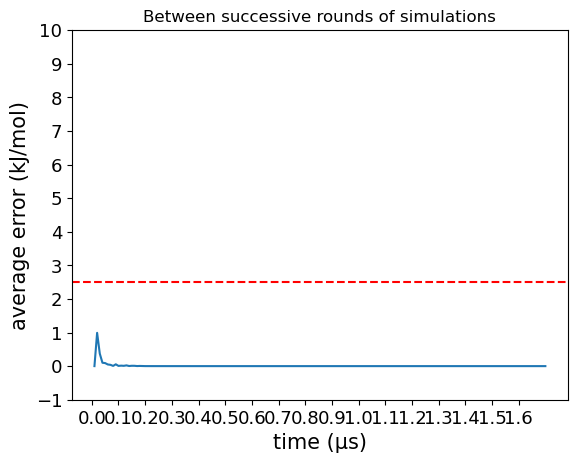

In [47]:
x=[]
y=[]
for i in Error:
    x.append(i[0])
    if i[1]>10:
        i[1]=10 # considering inf as 10 in the plot
    y.append(i[1])
    
plt.plot(x,y)
plt.xticks(np.arange(0, max(x),0.1))
plt.yticks(np.arange(-1, 11, 1))
kt=kb*temperature
plt.axhline(y=kt, color="red", linestyle="--")

plt.xlabel(u"time (\u03bcs)",fontsize=15)
plt.ylabel("average error (kJ/mol)",fontsize=15)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.title("Between successive rounds of simulations")

In [ ]:
Error

In [ ]:
# convergence wrt final FES

Error2=[]

H1, _,_ = np.histogram2d(Q, RMSD, weights=weights, bins=(120,120),range=[[Qmin,Qmax],[RMSDmin,RMSDmax]])
H1 = H1.T
H1=-(1/beta)*np.log(gaussian_filter(H1,sigma=3))
H1-= np.amin(H1)

count=0
ignore=1000

while ignore < md_length:
    
    Q2=Q[:ignore*6]
    RMSD2=RMSD[:ignore*6]
    wt2=weights[:ignore*6]

    H2, _,_= np.histogram2d(Q2, RMSD2, weights=wt2, bins=(120,120),range=[[Qmin,Qmax],[RMSDmin,RMSDmax]])
    H2 = H2.T
    H2=-(1/beta)*np.log(gaussian_filter(H2,sigma=3))
    H2-= np.amin(H2)

    #Error= Delta F where F of WTM is < 10 

    F_10 =0
    N_grids = 0
    for i in range(120):
        for j in range(120):
                if H1[i,j]<10:
                    F_10 += math.sqrt((H2[i,j]-H1[i,j])**2)
                    N_grids +=1
    diff = F_10/N_grids
    Error2.append ([ignore*(10**-5),diff])

    ignore+=1000
    count+=1


/tmp/ipykernel_3119762/3810066764.py:7: RuntimeWarning: divide by zero encountered in log
  H1=-(1/beta)*np.log(gaussian_filter(H1,sigma=3))
/tmp/ipykernel_3119762/3810066764.py:21: RuntimeWarning: divide by zero encountered in log
  H2=-(1/beta)*np.log(gaussian_filter(H2,sigma=3))


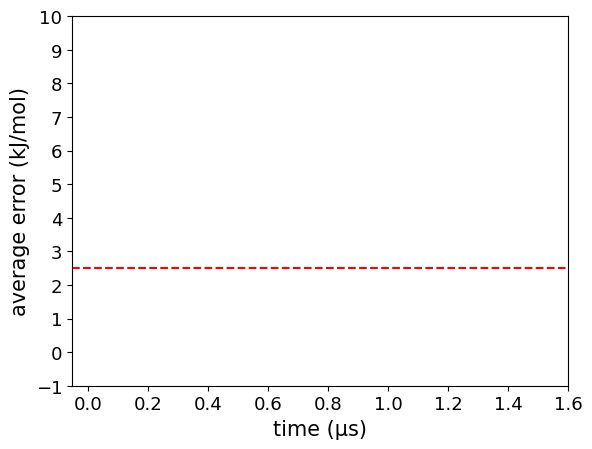

In [22]:
x=[]
y=[]
for i in Error2:
    x.append(i[0])
    if i[1]>10:
        i[1]=10 # considering inf as 10 in the plot
    y.append(i[1])
    
plt.plot(x,y)
plt.xticks(np.arange(0, max(x),0.2))
plt.yticks(np.arange(-1, 11, 1))
kt=kb*temperature
plt.axhline(y=kt, color="red", linestyle="--")

plt.xlabel(u"time (\u03bcs)",fontsize=15)
plt.ylabel("average error (kJ/mol)",fontsize=15)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
#plt.title("With respect to final FES")
plt.show()

In [28]:
# convergence wrt PTWTM

Error3=[]

# WTM
data=np.genfromtxt("/project/zerze/ayushg/argonne/ddmd/analysis/FED/colvar_PTWTE_WTM_Gul")
ignore=25000
bias=np.copy(data[ignore:,3]+data[ignore:,9]+data[ignore:,12]+data[ignore:,14])
cmap=np.copy(data[ignore:,7])
rmsd=np.copy(data[ignore:,17])*10.0 # to convert from nm to A

logweights2 = beta*bias
logweights2 -= np.amax(logweights2)
weights2 = np.exp(logweights2)

rmsd_lim_min=min(min(rmsd),min(RMSD))
rmsd_lim_max=max(max(rmsd),max(RMSD))

H1, _,_ = np.histogram2d(cmap, rmsd, weights=weights2, bins=(120,120),range=[[Qmin,Qmax],[rmsd_lim_min,rmsd_lim_max]])
H1 = H1.T
H1=-(1/beta)*np.log(gaussian_filter(H1, sigma=3))
H1 -= np.amin(H1) 

count=0
ignore=2000

while ignore < md_length:
    
    Q2=Q[:ignore*6]
    RMSD2=RMSD[:ignore*6]
    wt2=weights[:ignore*6]

    H2, _,_= np.histogram2d(Q2, RMSD2, weights=wt2, bins=(120,120),range=[[Qmin,Qmax],[rmsd_lim_min,rmsd_lim_max]])
    H2 = H2.T
    H2=-(1/beta)*np.log(gaussian_filter(H2,sigma=3))
    H2-= np.amin(H2)

    #Error= Delta F where F of WTM is < 10 

    F_10 =0
    N_grids = 0
    for i in range(120):
        for j in range(120):
                if H1[i,j]<10:
                    F_10 += math.sqrt((H2[i,j]-H1[i,j])**2)
                    N_grids +=1
    diff = F_10/N_grids
    Error3.append ([ignore*(10**-5),diff])

    ignore+=1000
    count+=1


/tmp/ipykernel_1980152/3497636344.py:21: RuntimeWarning: divide by zero encountered in log
  H1=-(1/beta)*np.log(gaussian_filter(H1, sigma=3))
/tmp/ipykernel_1980152/3497636344.py:35: RuntimeWarning: divide by zero encountered in log
  H2=-(1/beta)*np.log(gaussian_filter(H2,sigma=3))


In [18]:
"""Calculate the free energy difference between two phases for PTWTM.

    Args:
        CV (numpy array): An array with the collective variable values
        bias (numpy array): An array with the bias values in kJ/mol
        temperature (float): The temperature in K
        CVlimit (float): Watershed between the two phases (CVunits)

    Returns:
        float: the free energy in kJ/mol
    """
    #beta=1./(0.00831441001626*temperature) # 1/(kJ/mol)
condition_F=np.logical_and(rmsd<2,cmap>0.9) # folded
condition_U=np.logical_and(6<rmsd,rmsd<8,cmap<0.11) # unfolded
condition_M=np.logical_and(3<rmsd,rmsd<4,cmap>0.9) # misfolded
probF=np.sum(np.exp(logweights2[condition_F]))
probU=np.sum(np.exp(logweights2[condition_U]))
probM=np.sum(np.exp(logweights2[condition_M]))
FE_FU=-(1./beta)*np.log(probF/probU)
FE_MU=-(1./beta)*np.log(probM/probU)
FE_MF=-(1./beta)*np.log(probM/probF)
print (FE_FU, FE_MU, FE_MF)

-6.407472171008829 -6.172313489738137 0.23515868127069123


In [31]:
df_F= df[(df.rmsd < 2) & (df.Q > 0.9)]
df_U= df[(df.rmsd > 6) & (df.rmsd < 8) & (df.Q < 0.1)]
df_M= df[(df.rmsd > 3) & (df.rmsd < 4) & (df.Q > 0.9)]

total_weight= np.sum(df['weight'].values.tolist())
probF= np.sum(df_F['weight'].values.tolist())/total_weight
probU= np.sum(df_U['weight'].values.tolist())/total_weight
probM= np.sum(df_M['weight'].values.tolist())/total_weight
FE_FU=-(1./beta)*np.log(probF/probU)
FE_MU=-(1./beta)*np.log(probM/probU)
FE_MF=-(1./beta)*np.log(probM/probF)
print (len(df_F), len(df_U), len(df_M))
print (probF, probU, probM)
print (FE_FU, FE_MU, FE_MF)

36557 164910 7634
0.6343789176761269 0.04175287223005628 0.02652634148692397
-6.786789870166631 1.1315065150186592 7.91829638518529


Text(0.5, 1.0, 'wrt PTWTM')

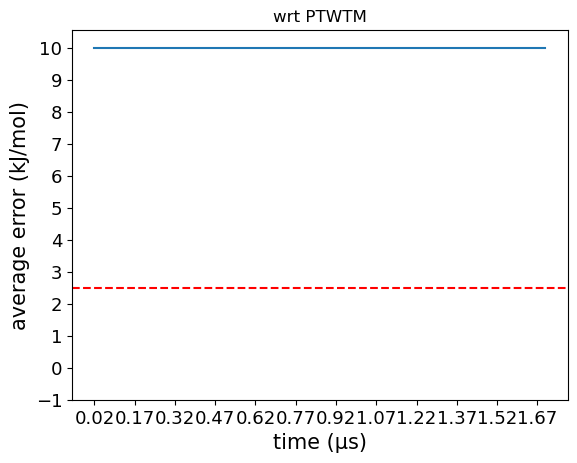

In [29]:
x=[]
y=[]
for i in Error3:
    x.append(i[0])
    if i[1]>10:
        i[1]=10 # considering inf as 10 in the plot
    y.append(i[1])
    
plt.plot(x,y)
plt.xticks(np.arange(min(x), max(x),0.15))
plt.yticks(np.arange(-1, 11, 1))
kt=kb*temperature
plt.axhline(y=kt, color="red", linestyle="--")

plt.xlabel(u"time (\u03bcs)",fontsize=15)
plt.ylabel("average error (kJ/mol)",fontsize=15)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.title("wrt PTWTM")

In [ ]:
Error3